In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MultiLabelBinarizer
import tqdm
import csv
import gensim
import random
from sklearn.decomposition import PCA
import pyreadr

%config IPCompleter.greedy=True

In [2]:
DIRECTORY = '/Users/diyahirc/Documents/BCM/genesets/pathway25y.gmt' # Change to your path

In [3]:
resultCaps = pyreadr.read_r('pfocr_figures.rds') # also works for RData

In [4]:
resultGenes = pyreadr.read_r('pfocr_genes.rds')

# Collecting and Parsing Captions 

In [5]:
capsDf = resultCaps[None]
print(capsDf.head())

                                        figid       pmcid  \
0  PMC5653847__41598_2017_14124_Fig8_HTML.jpg  PMC5653847   
1            PMC4187043__zh20191474070013.jpg  PMC4187043   
2            PMC5746550__rsob-7-170228-g1.jpg  PMC5746550   
3           PMC4211692__pone.0110875.g008.jpg  PMC4211692   
4                PMC2588433__nihms78212f8.jpg  PMC2588433   

                         filename    number  year  pathway_score  \
0  41598_2017_14124_Fig8_HTML.jpg  Figure 8  2017       0.968270   
1            zh20191474070013.jpg   Fig. 13  2014       0.965793   
2            rsob-7-170228-g1.jpg  Figure 1  2017       0.962470   
3           pone.0110875.g008.jpg  Figure 8  2014       0.966721   
4                nihms78212f8.jpg  Figure 8   NaN       0.966758   

   pmc_ranked_result_index                                            figlink  \
0                   133303              /pmc/articles/PMC5653847/figure/Fig8/   
1                    79929               /pmc/articles/PMC4187

In [6]:
uniqueCapIDs = pd.unique(capsDf['figid'])
print(uniqueCapIDs)
print(len(uniqueCapIDs))


['PMC5653847__41598_2017_14124_Fig8_HTML.jpg'
 'PMC4187043__zh20191474070013.jpg' 'PMC5746550__rsob-7-170228-g1.jpg' ...
 'PMC3651446__pnas.1220523110fig06.jpg'
 'PMC6770832__cancers-11-01236-g005.jpg'
 'PMC4609065__12885_2015_1721_Fig5_HTML.jpg']
64643


In [58]:
type(resultGenes)
geneDf = resultGenes[None]

geneLists = []

uniqueGeneIDs = pd.unique(geneDf['figid'])
print(len(uniqueGeneIDs))
currentInd = 0

NameError: name 'resultGenes' is not defined

### Creating Dictionary Storing FigTitle: Genes + Caps 

In [21]:
geneDict = {}

# Getting captions for each figure
for ind,row in tqdm.tqdm(capsDf.iterrows()):
    figId = row['figid']
    caption = row['caption']
    genes = set()
    geneDict[figId] = {'caption':caption, 'genes':genes}

64643it [00:05, 10782.98it/s]


In [22]:
# Getting genes for each figure
for ind,row in tqdm.tqdm(geneDf.iterrows()):
    figId = row['figid']
    symbol = row['symbol']
    geneDict[figId]['genes'].add(symbol)

1112551it [01:30, 12323.04it/s]


In [24]:
count = 0
removedFigsList = []
for fig in geneDict.keys():
    if len(geneDict[fig]['genes']) == 0:
        count += 1
        removedFigsList.append(fig)

for fig in removedFigsList:
    del geneDict[fig]

print('Number of geneless figures:  ', count)
print('Remaining number of figures: ',len(geneDict))

Number of geneless figures:   0
Remaining number of figures:  58962


In [2]:
caps = pd.DataFrame.from_dict(geneDict, orient='index')
caps.to_csv('pfocr_captions.csv')
caps.head()

NameError: name 'geneDict' is not defined

### Read consolidated data

In [198]:
caps = pd.read_csv('pfocr_captions.csv')
caps.head()

,Unnamed: 0,caption,genes
0,PMC5653847__41598_2017_14124_Fig8_HTML.jpg,Model of FTY720-induced transporter endocytosi...,"{'ARRESTIN', 'RSP5', 'mTORC1', 'TORC1'}"
1,PMC4187043__zh20191474070013.jpg,Proposed signaling pathway by which the stimul...,"{'PDE3', 'PLC', 'PKA', 'AT2', 'PKC', 'PTK', 'A..."
2,PMC5746550__rsob-7-170228-g1.jpg,Aβ production. In the amyloidogenic pathway (r...,"{'CSE-C', 'ASS'}"
3,PMC4211692__pone.0110875.g008.jpg,Glucolipotoxicity impairs CERT- and vesicular-...,"{'CERT', 'CERS4', 'AKT'}"
4,PMC2588433__nihms78212f8.jpg,Bacterial Sia biosynthesis can be divided into...,"{'CMP', 'NEU'}"


In [199]:
def removeWordCriteria(word,frequency):
    if frequency < 5:
        return True
    if frequency > 15000: # misc words like 'that','the','a',...etc
        return True
    if len(word) < 4: # meaningless words that are 3 letters long
        return True
    return False

In [200]:
import re

captionList = []
captionIndex = []

for ind,caption in tqdm.tqdm(enumerate(caps['caption'])):
    if type(caption) == str: # some numeric captions break this
        caption = caption.replace('-', ' ') # removing hyphens
        postCaption = re.sub(r'[^\w\s]+', '', caption) #removing punctuations
        postCaption = postCaption.upper()
        captionList.append(postCaption.split(' '))
        captionIndex.append(ind)

58962it [00:05, 10035.66it/s]


In [201]:
from collections import Counter

wordCounter = Counter()
for wordList in tqdm.tqdm(captionList):
    for word in wordList:
        wordCounter[word] += 1


100%|██████████| 58912/58912 [00:02<00:00, 24831.94it/s]


In [202]:
freq = list(wordCounter.items())
freq.sort(key=lambda x: x[1])
# print('Least frequent words: ')
# print(freq[126055-40:126055+40])

print('Most Frequent words: ')
print(freq[-100:-50])

print('\n')
print('Total word count: ',len(freq))

removableWords = []
wordsRemovalCount = 0
for pair in freq:
    if removeWordCriteria(pair[0],pair[1]):
        wordsRemovalCount += 1
        removableWords.append(pair[0])
        
removableWords = set(removableWords)
print('Words to remove:  ',wordsRemovalCount)

Most Frequent words: 
[('T', 8259), ('BETWEEN', 8272), ('INVOLVED', 8275), ('TARGET', 8279), ('REGULATED', 8368), ('INCREASED', 8395), ('APOPTOSIS', 8426), ('ARROWS', 8514), ('4', 8531), ('FACTORS', 8662), ('ΚB', 8702), ('LEVELS', 8754), ('ACTIVATE', 8772), ('CYCLE', 8791), ('6', 8818), ('NF', 8826), ('5', 8908), ('BOTH', 8956), ('MODEL', 9234), ('IT', 9291), ('PRODUCTION', 9331), ('DNA', 9414), ('LEADS', 9477), ('LEADING', 9544), ('OTHER', 9602), ('PHOSPHATE', 9622), ('INHIBITION', 9674), ('ASSOCIATED', 9695), ('RECEPTORS', 9937), ('REGULATION', 10083), ('SYNTHESIS', 10199), ('INDUCED', 10448), ('IL', 10582), ('THESE', 10727), ('GROWTH', 10968), ('SUCH', 11059), ('MEMBRANE', 11104), ('ACTIVATES', 11196), ('NOT', 11270), ('RED', 11550), ('MAY', 12023), ('ACID', 12316), ('INTO', 12650), ('RESPONSE', 12803), ('MEDIATED', 12818), ('ITS', 12822), ('SHOWN', 12867), ('DEPENDENT', 12924), ('Β', 13322), ('PHOSPHORYLATION', 13832)]


Total word count:  149177
Words to remove:   118656


In [203]:
filteredWordList = []

for wordList in tqdm.tqdm(captionList):
    tempList = []
    for word in wordList:
        if word not in removableWords:
            tempList.append(word)
    filteredWordList.append(set(tempList))

print('Example captions: ')
print(filteredWordList[:3])


100%|██████████| 58912/58912 [00:01<00:00, 37232.02it/s]

Example captions: 
[{'CONTRIBUTES', 'RESPONDING', 'MECHANISM', 'CAUSES', 'CONTRIBUTING', 'TRANSPORTER', 'FUNCTIONS', 'STIMULATION', 'SUPPLIED', 'MODEL', 'CONTROL', 'DEPENDENT', 'ADDITION', 'ELICITS', 'REDUCED', 'FAMILY', 'INHIBITS', 'ENDOCYTOSIS', 'PERMEASE', 'INCLUDING', 'FTY720', 'INHIBITION', 'INDUCED', 'BOTH', 'FACTORS', 'RSP5', 'MTORC1', 'REGULATED', 'INTO', 'STIMULATES', 'PP2A', 'MEMBRANE', 'MACHINERY', 'MOLECULES', 'DECREASE', 'LIGASE', 'ABILITY', 'SIMILARLY', 'UNKNOWN', 'PLASMA', 'UBIQUITIN', 'INVOLVING', 'HUMAN', 'AMINO', 'RESULTING', 'SURFACE', 'ACID', 'UBIQUITYLATION', 'UPTAKE', 'THEN', 'TORC1', 'MAMMALIAN', 'SOMEHOW', 'ADAPTOR', 'GROWTH', 'EXOGENOUSLY', 'PRESENCE', 'UNDER', 'ALTERS', 'PERMEASES', 'POSSIBLY', 'PROMOTE', 'INFLUENCES', 'ENDOCYTIC', 'PROMOTES', 'INHERENT', 'TRIGGERING', 'THEREBY', 'YEAST', 'PHOSPHATASE', 'ARRESTIN', 'NUTRIENT', 'CAUSING', 'SORTING', 'REGULATING', 'TRANSPORTERS', 'AVAILABILITY', 'ACTIVATE', 'STABILITY', 'INTRINSIC', 'INSERT', 'FURTHER'}, {'PHOSP

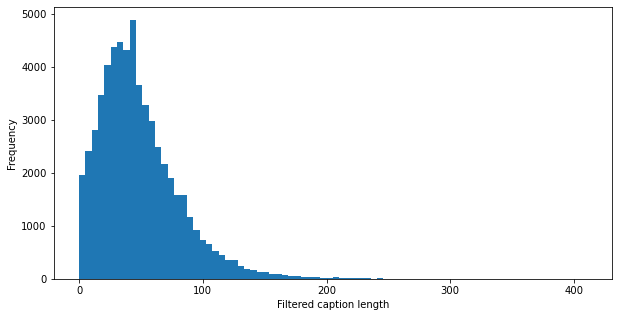

DescribeResult(nobs=58912, minmax=(0, 410), mean=48.49193712656165, variance=1044.8755269836722, skewness=1.3775484909775484, kurtosis=3.50505456218898)


In [204]:
filteredLens = [ len(wordList) for wordList in filteredWordList ] 
plt.figure(figsize=(10,5))
plt.hist(filteredLens,bins = 80)
plt.ylabel('Frequency')
plt.xlabel('Filtered caption length')
plt.show()

print(stats.describe(filteredLens))

In [302]:
# WORDSOFINTEREST = ['DIABETES','DEPRESSION','PARKINSONS','HEART','LUNG','BONE','BRAIN','SPLEEN','OVARY']
# WORDSOFINTEREST = ['DIABETES','PARKINSONS','BLOOD','BRAIN','HEART','LUNG','SKIN']
WORDSOFINTEREST = ['PARKINSONS','ARTHRITIS','ALZHEIMERS','OVARY','SPLEEN']
# WORDSOFINTEREST = ['OVARY','SPLEEN']


indicies = {} ## Mapping words to gene-set index

for word in WORDSOFINTEREST:
    tempUniqueSetCount = 0
    tempInds = []

    for indx, wordList in enumerate(filteredWordList):
        if word in wordList:
            tempUniqueSetCount += 1
            tempInds.append(indx)
        if len(tempInds) > 0:
            indicies[word] = tempInds
    print('{word} appears {count} times in {unique} sets'.format(word=word,
                                                                 count=wordCounter[word],
                                                                 unique=tempUniqueSetCount))

PARKINSONS appears 183 times in 139 sets
ARTHRITIS appears 115 times in 87 sets
ALZHEIMERS appears 272 times in 227 sets
OVARY appears 101 times in 70 sets
SPLEEN appears 206 times in 163 sets


In [303]:
from gensim.models import KeyedVectors

MODELPATH = "/Users/diyahirc/Files/BCM/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_60.model"
geneModel = KeyedVectors.load(MODELPATH)

# gene2vecMODELPATH = "/Users/diyahirc/Files/BCM/gen2vec/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9_w2v.txt"
# geneModel = gensim.models.KeyedVectors.load_word2vec_format(gene2vecMODELPATH)

In [304]:
def getVecsInVocab(geneSets,model,removeOverlap:bool):
    vecs = []
    alreadySeen = Counter()
    for gene in geneSets:
        if alreadySeen[gene] == 0:
            alreadySeen[gene] += 1
            if gene in model.wv.vocab:
                tempVec = model.wv[gene]
                vecs.append(tempVec)
    
    return np.array(vecs)

In [305]:
## Taking all the genesets and creating an array of their avg vectors + their one-hot-encodings
geneSetAvgVec = []
breaks = [0]
oneHotVecs = []
removeOverlap = True

for oneHotInd,WORD in enumerate(WORDSOFINTEREST):
    tempOneHot = np.zeros(len(WORDSOFINTEREST))
    tempOneHot[oneHotInd] = 1
    for index in indicies[WORD]:
        geneSets = eval(caps['genes'][index])
        vecs = getVecsInVocab(geneSets,geneModel,removeOverlap)
        if len(vecs) > 0:
            geneSetAvgVec.append(np.average(vecs,axis=0))
            oneHotVecs.append(tempOneHot)
    breaks.append(len(geneSetAvgVec))

oneHotVecs = np.array(oneHotVecs)
geneSetAvgVec = np.array(geneSetAvgVec)
print('Shape of average vecs')
print(geneSetAvgVec.shape)
print('\n')
print('Shape of One-Hot-Encoding')
print(oneHotVecs.shape)

Shape of average vecs
(553, 200)


Shape of One-Hot-Encoding
(553, 5)


In [306]:
## Taking all the genesets and creating an array of the gene vecs and categorical one-hot-encoding
geneSetAvgVec = []
breaks = [0]
oneHotVecs = []

for oneHotInd,WORD in enumerate(WORDSOFINTEREST):
    tempOneHot = np.zeros(len(WORDSOFINTEREST))
    tempOneHot[oneHotInd] = 1
    for index in indicies[WORD]:
        geneSet = eval(caps['genes'][index])
        vecs = getVecsInVocab(geneSet,geneModel,True)
        if len(vecs) > 0: # sometimes no overlap and crashes
            geneSetAvgVec = geneSetAvgVec + vecs.tolist()
            for i in range(len(vecs)):     
                oneHotVecs.append(tempOneHot)
    breaks.append(len(geneSetAvgVec))
    

oneHotVecs = np.array(oneHotVecs)
geneSetAvgVec = np.array(geneSetAvgVec)

perm = np.arange(geneSetAvgVec.shape[0])
np.random.shuffle(perm)

oneHotVecs = oneHotVecs[perm]
geneSetAvgVec = geneSetAvgVec[perm]

print('Shape of gene vecs')
print(geneSetAvgVec.shape)
print('Shape of One-Hot-Encoding')
print(oneHotVecs.shape)
print('Shape of unique genes')

geneSetAvgVec,indexs = np.unique(geneSetAvgVec,return_index=True,axis=0)
oneHotVecs = oneHotVecs[indexs,:]
print(geneSetAvgVec.shape)
print(np.mean(oneHotVecs,axis=0))

Shape of gene vecs
(3281, 200)
Shape of One-Hot-Encoding
(3281, 5)
Shape of unique genes
(1558, 200)
[0.21 0.14 0.35 0.08 0.22]


In [306]:
## Taking all the genesets and creating an array of the gene vecs and categorical one-hot-encoding

def getGeneVecsAndOneHot(WORDSOFINTEREST:list,):
    geneSetAvgVec = []
    breaks = [0]
    oneHotVecs = []

    for oneHotInd,WORD in enumerate(WORDSOFINTEREST):
        tempOneHot = np.zeros(len(WORDSOFINTEREST))
        tempOneHot[oneHotInd] = 1
        for index in indicies[WORD]:
            geneSet = eval(caps['genes'][index])
            vecs = getVecsInVocab(geneSet,geneModel,True)
            if len(vecs) > 0: # sometimes no overlap and crashes
                geneSetAvgVec = geneSetAvgVec + vecs.tolist()
                for i in range(len(vecs)):     
                    oneHotVecs.append(tempOneHot)
        breaks.append(len(geneSetAvgVec))


    oneHotVecs = np.array(oneHotVecs)
    geneSetAvgVec = np.array(geneSetAvgVec)

    perm = np.arange(geneSetAvgVec.shape[0])
    np.random.shuffle(perm)

    oneHotVecs = oneHotVecs[perm]
    geneSetAvgVec = geneSetAvgVec[perm]

    print('Shape of gene vecs')
    print(geneSetAvgVec.shape)
    print('Shape of One-Hot-Encoding')
    print(oneHotVecs.shape)
    print('Shape of unique genes')

    geneSetAvgVec,indexs = np.unique(geneSetAvgVec,return_index=True,axis=0)
    oneHotVecs = oneHotVecs[indexs,:]
    print(geneSetAvgVec.shape)
    print(np.mean(oneHotVecs,axis=0))

Shape of gene vecs
(3281, 200)
Shape of One-Hot-Encoding
(3281, 5)
Shape of unique genes
(1558, 200)
[0.21 0.14 0.35 0.08 0.22]


In [307]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

export_dir = "/Users/diyahirc/Files/BCM/trained_embeddings/alldata/"

def reduce_dimensions(vecs):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays

    #     vectors = np.asarray(model.wv.vectors)
    #     labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings
    
    vectors = vecs
    pca = PCA(n_components=30)
    pca.fit(vectors)
    vectors=pca.transform(vectors)    
    print('PCA Complete')
    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=30)
    vectors = tsne.fit_transform(vectors)
    print('TSNE Complete')

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

# gene2vecModel = '/Users/diyahirc/Files/BCM/gen2vec/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9.txt'
# model = gensim.models.Word2Vec.load(gene2vecModel)

# MODELPATH = "/Users/diyahirc/Files/BCM/gen2vec/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9_w2v.txt"
# model = gensim.models.KeyedVectors.load_word2vec_format(MODELPATH)

# model = gensim.models.Word2Vec.load(export_dir+"gene2vec_dim_v2_"+str(200)+"_iter_"+str(60)+'.model')

x_vals, y_vals, labels = reduce_dimensions(geneSetAvgVec)

PCA Complete
TSNE Complete


In [308]:
print(breaks)

[0, 734, 1155, 2270, 2562, 3281]


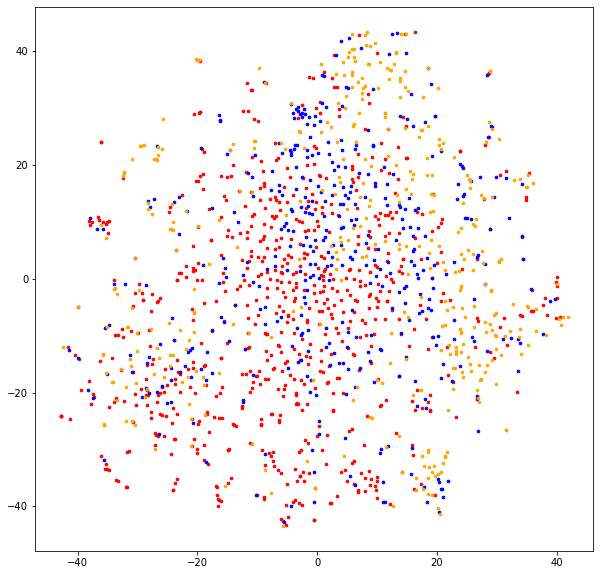

In [309]:
plt.figure(figsize=(10,10))
colors = ['red','blue','orange','green','yellow','black']
for breakInd in range(len(breaks)-1):
    start = breaks[breakInd]
    end = breaks[breakInd + 1]
    color = colors[breakInd]
    plt.scatter(x_vals[start:end],y_vals[start:end],s=7,c=color)

plt.show()

In [337]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

export_dir = "/Users/diyahirc/Files/BCM/trained_embeddings/alldata/"

def reduce_dimensions(model,vecs):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings
    print(labels.shape)
    
    vectors = np.vstack((vectors,vecs))
    pca = PCA(n_components=30)
    pca.fit(vectors)
    vectors=pca.transform(vectors)    
    print('PCA Complete')
    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=30)
    vectors = tsne.fit_transform(vectors)
    print('TSNE Complete')

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

model = gensim.models.Word2Vec.load(export_dir+"gene2vec_dim_v2_"+str(200)+"_iter_"+str(10)+'.model')
print(geneSetAvgVec.shape)
x_vals, y_vals, labels = reduce_dimensions(model,geneSetAvgVec)
x_vals2v, y_vals2v, labels2v = reduce_dimensions(gene2vecModel,geneSetAvgVec)

(1558, 200)
(12254,)
PCA Complete
TSNE Complete
(24447,)


<ipython-input-337-8fc5c784500c>:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vectors = np.asarray(model.wv.vectors)
<ipython-input-337-8fc5c784500c>:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings


PCA Complete
TSNE Complete


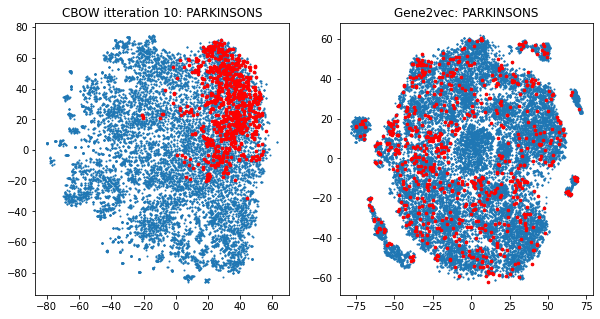

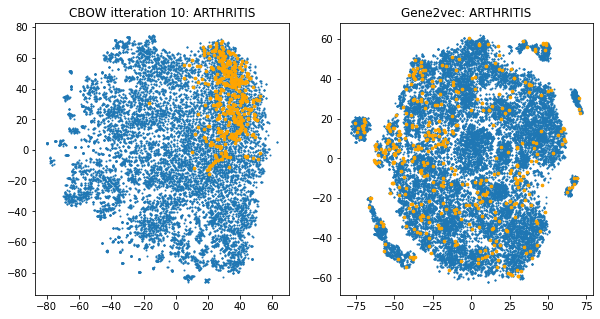

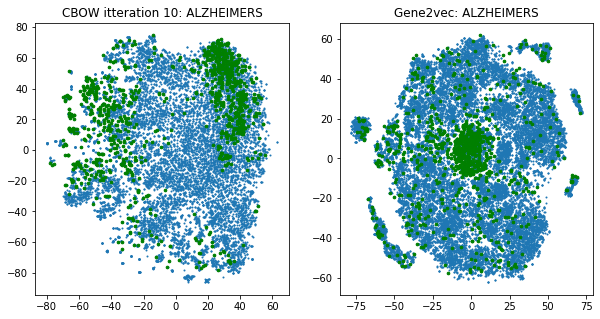

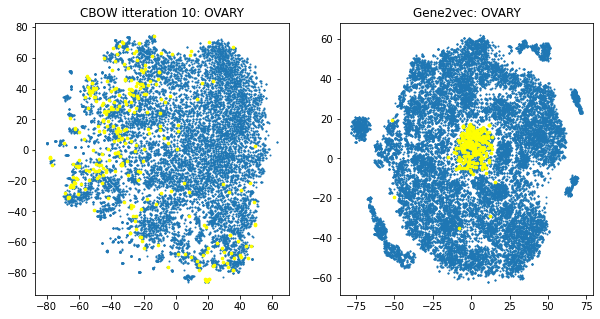

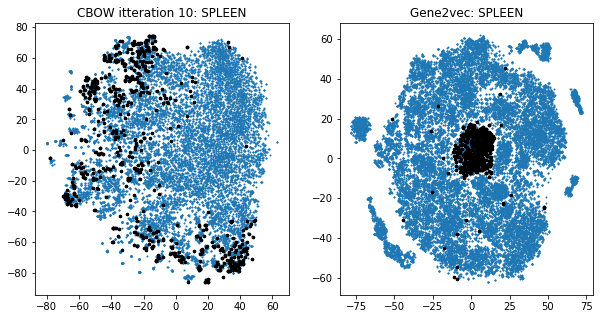

In [339]:
colors = ['red','orange','green','yellow','black']
# plt.figure(figsize=(10,10))

for breakInd in range(len(breaks)-1):
    start = breaks[breakInd]-breaks[-1]
    end = breaks[breakInd + 1]-breaks[-1]
    if end == 0:
        end = -1
#     print(start," - ",end)
    color = colors[breakInd]
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title('CBOW itteration 10: '+WORDSOFINTEREST[breakInd])
    plt.scatter(x_vals,y_vals,s=1)
    plt.scatter(x_vals[start:end],y_vals[start:end],s=7,c=color)
    
    plt.subplot(1, 2, 2)
    plt.title('Gene2vec: '+WORDSOFINTEREST[breakInd])
    plt.scatter(x_vals2v,y_vals2v,s=1)
    plt.scatter(x_vals2v[start:end],y_vals2v[start:end],s=7,c=color)
    plt.show()
    

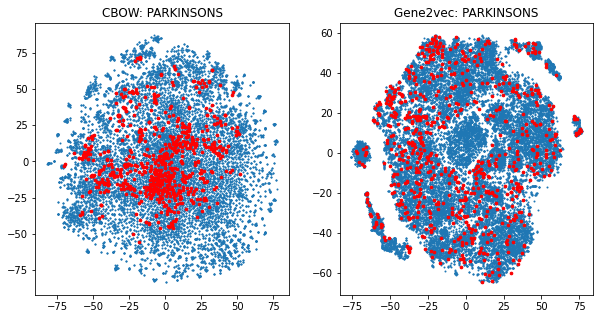

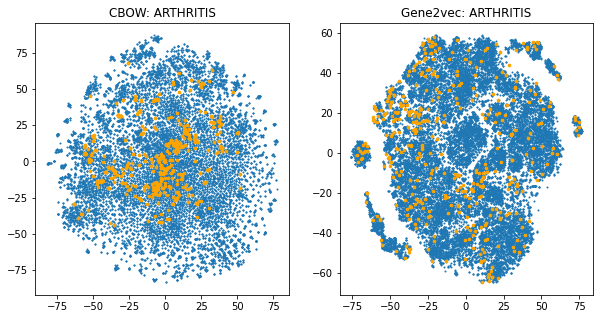

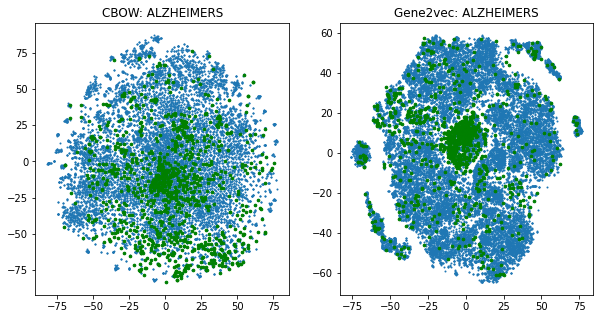

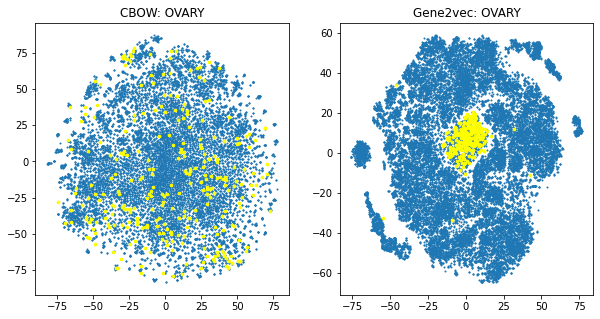

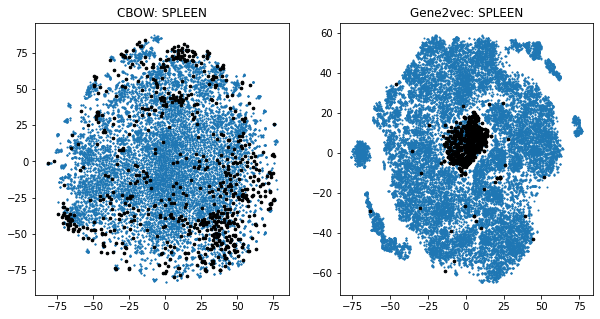

In [336]:
colors = ['red','orange','green','yellow','black']
# plt.figure(figsize=(10,10))

for breakInd in range(len(breaks)-1):
    start = breaks[breakInd]-breaks[-1]
    end = breaks[breakInd + 1]-breaks[-1]
    if end == 0:
        end = -1
#     print(start," - ",end)
    color = colors[breakInd]
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title('CBOW: '+WORDSOFINTEREST[breakInd])
    plt.scatter(x_vals,y_vals,s=1)
    plt.scatter(x_vals[start:end],y_vals[start:end],s=7,c=color)
    
    plt.subplot(1, 2, 2)
    plt.title('Gene2vec: '+WORDSOFINTEREST[breakInd])
    plt.scatter(x_vals2v,y_vals2v,s=1)
    plt.scatter(x_vals2v[start:end],y_vals2v[start:end],s=7,c=color)
    plt.show()
    

In [312]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

pca = PCA(n_components=50)
pca.fit(geneSetAvgVec)

X_total = pca.transform(geneSetAvgVec) 
Y_total = oneHotVecs

scaler = preprocessing.StandardScaler().fit(X_total)
X_total = scaler.transform(X_total)

X_train, X_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.1, random_state=42)

clf = OneVsOneClassifier(SVC(random_state=0, max_iter=50)).fit(X_train, y_train.argmax(axis=1))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver termi

In [313]:
def convert2onehot(y_pred):
    y_new = []
    for chromNum in y_pred:
        tempAr = np.zeros(22)
        tempAr[chromNum] = 1
        y_new.append(tempAr)
    return np.array(y_new)

Confusion matrix, without normalization
Normalized confusion matrix


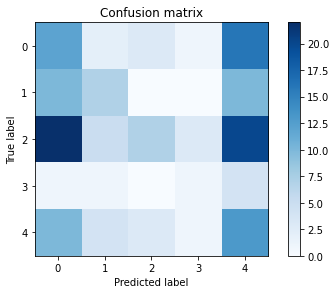

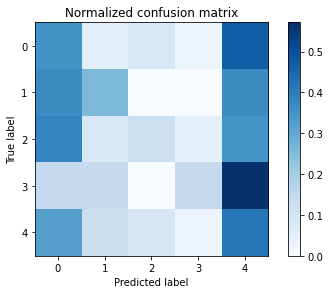

0.2564102564102564


In [314]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# y_pred = model.predict(X_test)
y_pred = convert2onehot(clf.predict(X_test))

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

accuracy = sum(y_test.argmax(axis=1) == y_pred.argmax(axis=1))
print(accuracy/len(y_test))

In [316]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train , epochs=50, batch_size=100, validation_split=0.1)
, callbacks=[EarlyStopping(monitor='val_loss', patience=10)],)

Epoch 1/50
13/13 [==============================] - 0s 8ms/step - loss: 1.6427 - accuracy: 0.1515 - val_loss: 1.6383 - val_accuracy: 0.2128
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 1.6262 - accuracy: 0.2014 - val_loss: 1.6280 - val_accuracy: 0.2695
Epoch 3/50
13/13 [==============================] - 0s 2ms/step - loss: 1.6134 - accuracy: 0.2347 - val_loss: 1.6193 - val_accuracy: 0.2837
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 1.6019 - accuracy: 0.2704 - val_loss: 1.6126 - val_accuracy: 0.2908
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 1.5918 - accuracy: 0.2895 - val_loss: 1.6059 - val_accuracy: 0.2979
Epoch 6/50
13/13 [==============================] - 0s 2ms/step - loss: 1.5823 - accuracy: 0.3037 - val_loss: 1.5996 - val_accuracy: 0.3050
Epoch 7/50
13/13 [==============================] - 0s 2ms/step - loss: 1.5733 - accuracy: 0.3101 - val_loss: 1.5932 - val_accuracy: 0.3050
Epoch 8/50
13/13 [==

("callbacks=[EarlyStopping(monitor='val_loss',", 'patience=10)],)')

Confusion matrix, without normalization
Normalized confusion matrix


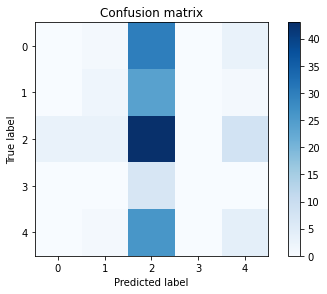

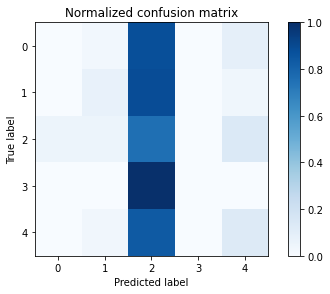

0.3141025641025641


In [317]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
# y_pred = convert2onehot(clf.predict(X_test))

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

accuracy = sum(y_test.argmax(axis=1) == y_pred.argmax(axis=1))
print(accuracy/len(y_test))

In [318]:
stats.describe(y_train)

DescribeResult(nobs=1402, minmax=(array([0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1.])), mean=array([0.21, 0.13, 0.35, 0.08, 0.23]), variance=array([0.17, 0.12, 0.23, 0.07, 0.18]), skewness=array([1.41, 2.15, 0.64, 3.06, 1.31]), kurtosis=array([-0.01,  2.61, -1.58,  7.39, -0.29]))